In [1]:
# Importing the various python libraries
import numpy as np # Python library used for working with arrays
import matplotlib.pyplot as plt # Aids in visualising
import os # Used to specify the locations of the file images
import cv2 # Converting images into arrays - for image processing tasks
from tqdm import tqdm # Able to obtain (visualise) a precentage bar for tasks

In [2]:
# Proprocessing the test set before testing it on the model 
DATADIR = r"C:\Files\Test Set" # Location of the file that consist of test set (COVID-19 & Non-COVID-19 images)

CATEGORIES = ["COVID", "NON-COVID"] # There are 2 folders respectively
IMG_SIZE = 100 # Resize image into 100 x 100 because input layer of Optimized scratch model is 100 x 100
testing_data = []

def create_training_data():

    for category in CATEGORIES: 

        path = os.path.join(DATADIR,category) # Joining of the 2 paths
        class_num = CATEGORIES.index(category) # 0 for COVID and 1 for NON-COVID

        for img in tqdm(os.listdir(path)):  
            
            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) # Convert to greyscale
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            testing_data.append([new_array, class_num]) # Place the features and labels into the testing_data []

# 1340 images (670 for both classes, as shown below)
create_training_data()

100%|██████████| 670/670 [00:01<00:00, 344.92it/s]


In [3]:
# Checking on the number images in the test set
len(testing_data)

1340

In [4]:
# In order to shuffle the test data randomly
import random

random.shuffle(testing_data) # Required to randomly shuffle the images so that are mixed well before feeding it to the model

In [5]:
# X - features, Y - labels
X = []
y = []
IMG_SIZE = 100

for features,label in testing_data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0 # Normalizing the features to keep it between 0-1
y = np.array(y)

In [6]:
x_out , y_out = X[199] , y[199] #Get 1 sample from the dataset for visualization

In [7]:
# Check on the shapes
print("Batch Image shape : {}".format(x_out.shape))
print("Batch Target shape : {}".format(y_out.shape))

Batch Image shape : (100, 100, 1)
Batch Target shape : ()


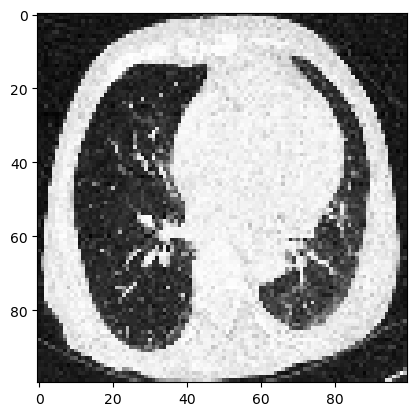

In [8]:
# For the visualisation of the images and the charts/Graphs 
import matplotlib.pyplot as plt

# Plot sample data (to see one of the images for visualisation)
plt.imshow(x_out.reshape(100,100) , cmap='gray')
plt.show()

In [9]:
# Import the various libraries and trained model previously saved (Optimized scratch model)
import numpy as np
import pandas as pd
import pickle
import os
import tensorflow as tf
import keras_tuner as tuner
from tensorflow import keras

import warnings # Earlier tensorflow version printing some warning , able to remove those warnings.
warnings.filterwarnings('ignore') 

my_model = keras.models.load_model("my_model") #Load the previously saved Optimized scratch model.

In [10]:
# Checking on the version on Tensorflow 
print(tf.__version__)

2.3.0


In [11]:
# 1340 featues and labels (100 x 100 x 1 (greyscale))
print(X.shape)
print(y.shape)

(1340, 100, 100, 1)
(1340,)


In [12]:
# Summary of the Optimized scratch model
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 128)       36992     
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0

In [13]:
# Evaluate the trained model on the test dataset
result = my_model.evaluate(X, y, verbose=1)

42/42 [==============================] - 2s 50ms/step - loss: 1.5819 - accuracy: 0.8366


In [14]:
prediction , target =[] ,[]

# Iterate over the images and target label, feeding into the model
for i_x , i_y in zip(X,y) :
  i_x = i_x[np.newaxis , : , : , :]

  
  model_pred = my_model.predict( i_x ) # Model prediction using the input images

  prediction.append(int(model_pred[0])) # Appending model prediction into a list
  target.append(i_y)

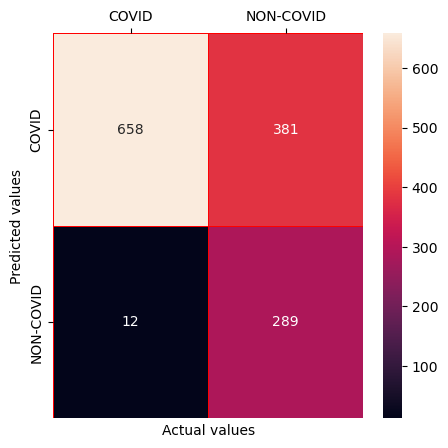

In [15]:
# Import the various libraries to develop and view the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the prediction and target into numpy arrays
y_pred = np.array(prediction)
y_true = np.array(target)

# 2 class names
names=["COVID","NON-COVID"]

# Build the confusion matrix with the true/actual labels and predicted labels
cm=confusion_matrix(y_true,y_pred).T
f,ax=plt.subplots(figsize=(5,5))

# Create heatmap with seaborn for better visualisation of the confusion matrix
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)

plt.xlabel("Actual values") #Plot the X & Y Axis
plt.ylabel("Predicted values")

# Set Y-axis & X-axis names as COVID and NON-COVID
ax.xaxis.tick_top()
ax.set_xticklabels(names)
ax.set_yticklabels(names)

plt.savefig('Model Confusion Matrix Graph')

# Show the confusion matrix below
plt.show()

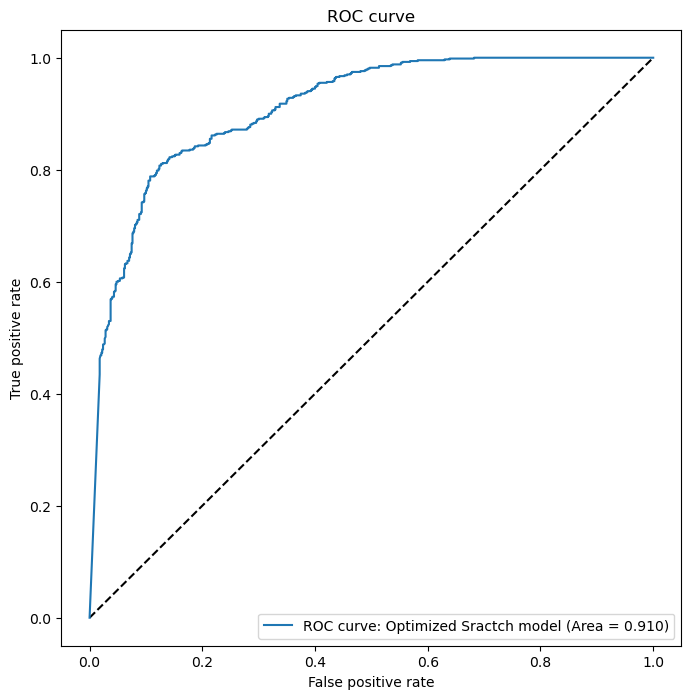

In [16]:
# Plotting the ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Get the model predictions for the test set
y_pred_keras = my_model.predict(X).ravel()

# Compute the false positive rate and true positive rates using sklearn function
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y, y_pred_keras)

# Compute the area under curve using sklearn function
auc_keras = auc(fpr_keras, tpr_keras)

# Set the plot figure size
fig = plt.figure(figsize=(8,8))
plt.figure(1)

# Plot configurations
# Plot the fpr with tpr , set the label
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC curve: Optimized Sractch model (Area = {:.3f})'.format(auc_keras))

#Plotting ROC curve: True positive rate vs False positive rate
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

# Plot title
plt.title('ROC curve')

# Set the plot legend location 
plt.legend(loc=4)

# Show the plot
plt.show()